In [1]:
import datetime
import json
import pathlib
import warnings
import eli5

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as linear_model
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression, ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook as tqdm

import seaborn as sns; sns.set()

import warnings; warnings.filterwarnings('ignore')

import random as rn
#rn.seed(1)
#np.random.seed(1)

Using TensorFlow backend.


# Загрузка данных

In [2]:
train_target = pd.read_csv('../input/sibur-pet-data/pet_target_train.csv', index_col='date', parse_dates=['date'])
test_target = pd.read_csv('../input/sibur-pet-data/pet_test_timestamps.csv', index_col='date', parse_dates=['date'])

daily = pd.read_csv('../input/sibur-pet-data/pet_daily.csv', index_col='date', parse_dates=['date'])
weekly = pd.read_csv('../input/sibur-pet-data/pet_weekly.csv', index_col='date', parse_dates=['date'])

In [3]:
round(weekly.isna().sum() / weekly.shape[0] * 100, 1)

paraxylene_CHN_USD          6.9
paraxylene_RT_USD           2.1
paraxylene_SEA_USD          2.6
pta_NEA_USD                63.5
ethylene_glycol_EU_EUR      2.1
ethylene_glycol_CHN_USD     4.0
dtype: float64

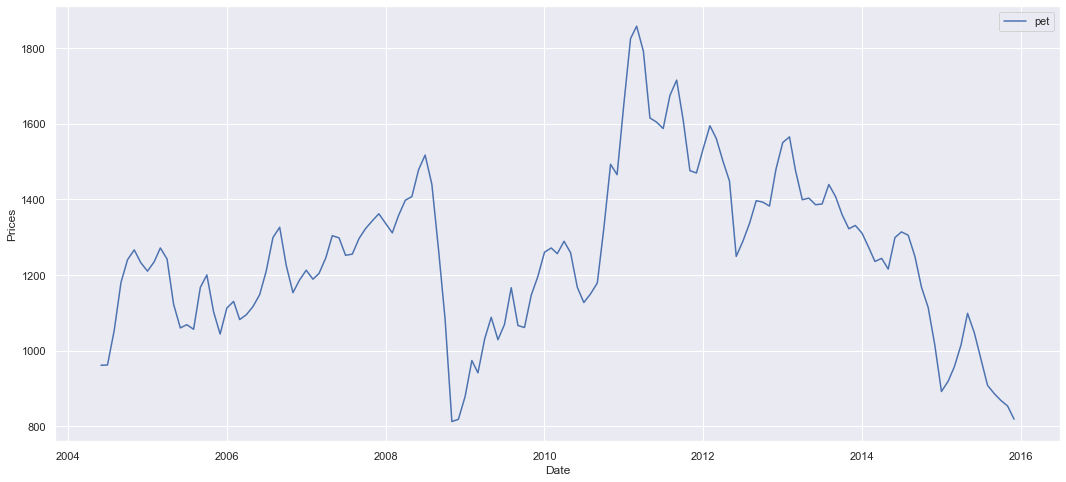

In [4]:
plt.figure(figsize=(18,8))

sns.lineplot(data=train_target, x=train_target.index , y='pet', label='pet')

plt.xlabel('Date')
plt.ylabel('Prices');

# Признаки

## Дневные данные

In [5]:
dfts = daily.resample('D').ffill()
wfts = weekly.resample('D').ffill()

fts = dfts.join(wfts)

In [6]:
PERIODS = ['4D', '5D', '6D', '7D', '8D', '9D', '1D', '30D', '60D', '21D']
AGGREGATES = ['mean', 'median', 'std', 'max', 'min']

all_features = []

for period in tqdm(PERIODS):
    for agg in AGGREGATES:
        if agg!='mean' and period=='1D':
            continue
        rolling_features = fts.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: '_'.join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features[rolling_features.index.day==9])
        
all_features = pd.concat(all_features, axis=1)

all_features['prediction_date'] = (
    all_features.index + pd.TimedeltaIndex(all_features.index.days_in_month-8, unit='D'))

# all_features

In [7]:
df = train_target.join(all_features.ffill().set_index('prediction_date'), how='outer')['2004-06':]
df.index.name = 'date'

In [8]:
df['month'] = df.index.month

df["dayofweek"] = df.index.dayofweek
df["weekofyear"] = df.index.weekofyear
df["weekday"] = df.index.weekday


FTS_COLS = df.columns[1:]
TARGET = 'pet'
df.shape

(182, 649)

In [9]:
df.tail(3)

,pet,brent_close_4D_mean,brent_open_4D_mean,brent_max_4D_mean,brent_min_4D_mean,USDCNY_close_4D_mean,USDCNY_open_4D_mean,USDCNY_max_4D_mean,USDCNY_min_4D_mean,paraxylene_CHN_USD_4D_mean,...,paraxylene_CHN_USD_21D_min,paraxylene_RT_USD_21D_min,paraxylene_SEA_USD_21D_min,pta_NEA_USD_21D_min,ethylene_glycol_EU_EUR_21D_min,ethylene_glycol_CHN_USD_21D_min,month,dayofweek,weekofyear,weekday
date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,NaN,70.5975,70.0025,70.8725,69.6425,6.716575,6.716275,6.719825,6.714225,1041.0,...,1041.0,950.0,1031.0,835.5,607.5,604.0,5,2,18,2
2019-06-01,NaN,70.4700,70.4625,71.1175,69.2250,6.787900,6.765000,6.799425,6.760525,912.0,...,912.0,840.0,902.0,835.5,575.0,584.0,6,5,22,5
2019-07-01,NaN,62.8850,61.9000,63.3000,61.3825,6.909700,6.911675,6.913750,6.909025,864.5,...,860.0,735.0,850.0,721.0,545.0,528.5,7,0,27,0


# Модели

## Линейные

In [10]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_pred-y_true)/y_true)) * 100, 4)

def line_model(model, df, sli, params, drop_cols=None, null_rank=None, corr_rank=None):
    full_df, tr, cv = df[:'2015'].copy(), df[:str(sli)].copy(), df[str(sli+1):'2015'].copy()
    print('Start:', tr.shape, cv.shape)
    
    if null_rank:
        null_cnt = round(full_df.drop(TARGET, axis=1).isna().sum() / full_df.shape[0] * 100, 1)
        null_colls = null_cnt[null_cnt > 0].index   

    if corr_rank:
        corrs = tr.corr().loc[TARGET, tr.columns[1:]]
        corrs_cols = corrs[corrs.abs() <= corr_rank].index
        
    print(
        'Drop len:', len(drop_cols),
        ' // Null len:', len(null_colls), '| Nulls unique:', sorted(null_cnt.unique()),
        f'// Corr < {corr_rank} len:', len(corrs_cols)
    )
    
    del_cols = drop_cols + list(null_colls) + list(corrs_cols) + [TARGET]
    FCOLS = [col for col in full_df.columns if col not in del_cols]
    print('After:', tr[FCOLS].shape, cv[FCOLS].shape)
    
    errors = []
    for param in tqdm(params):
        lmodel = eval(model)(**param)
        lmodel.fit(tr[FCOLS], tr[TARGET])

        ltr_preds = pd.Series(lmodel.predict(tr[FCOLS]), index=tr.index)
        lcv_preds = pd.Series(lmodel.predict(cv[FCOLS]), index=cv.index)

        cv_mape = mape(cv[TARGET], lcv_preds)
        errors.append({
            'mape': cv_mape,
            'param': param
        })

    errors = pd.DataFrame.from_records(errors)
    min_error = errors.iloc[errors['mape'].idxmin()]
    print(min_error['mape'], min_error['param'])
    
    lmodel = eval(model)(**min_error['param'])
    lmodel.fit(tr[FCOLS], tr[TARGET])
    
    ltr_preds = pd.Series(lmodel.predict(tr[FCOLS]), index=tr.index)
    lcv_preds = pd.Series(lmodel.predict(cv[FCOLS]), index=cv.index)

    plt.figure(figsize=(18,6))
    sns.lineplot(data=df, x=df.index ,y=TARGET, label='Full')
    sns.lineplot(x=ltr_preds.index ,y=ltr_preds.values, label='Train_pred')
    sns.lineplot(x=lcv_preds.index ,y=lcv_preds.values, label='Valid_pred', c='red')
    plt.title(model.split('.')[1])
    plt.xlabel('Date'); plt.ylabel('Prices')
    
    f_lmodel = eval(model)(**min_error['param'])
    f_lmodel.fit(full_df[FCOLS], full_df[TARGET])
    
    return lmodel, f_lmodel, FCOLS

### ElasticNet

Start: (127, 649) (12, 649)
Drop len: 1  // Null len: 92 | Nulls unique: [0.0, 5.8, 82.0] // Corr < 0.13 len: 75
After: (127, 489) (12, 489)



5.001 {'alpha': 0.1, 'copy_X': True, 'fit_intercept': False, 'l1_ratio': 1.5, 'max_iter': 12, 'normalize': False, 'positive': False, 'precompute': True, 'random_state': 17, 'selection': 'random', 'tol': 0.0001, 'warm_start': True}


Weight?,Feature
+35.623,brent_close_4D_std
+8.583,brent_min_9D_std
+5.896,USDCNY_close_21D_max
+4.561,USDCNY_max_4D_median
+3.637,USDCNY_close_9D_median
+2.661,USDCNY_max_7D_median
+2.370,USDCNY_open_9D_median
+2.340,USDCNY_min_9D_mean
+2.197,USDCNY_open_8D_max
+2.177,USDCNY_close_5D_mean


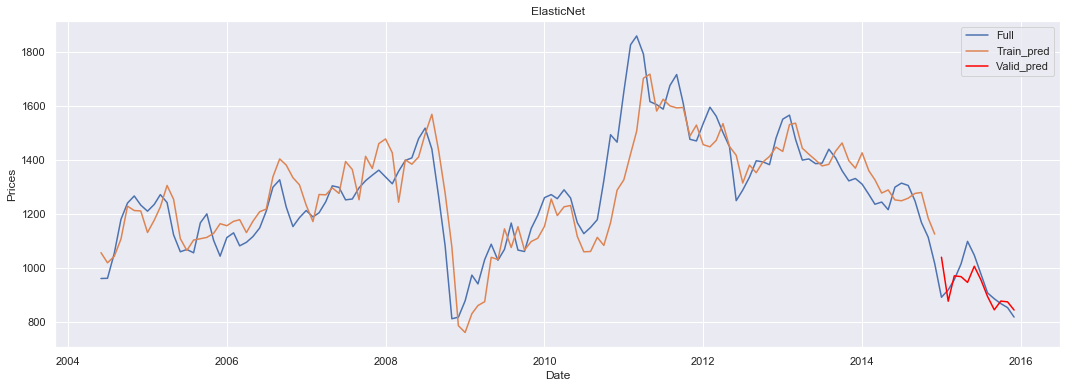

In [11]:
params = ParameterGrid({
    'alpha': [0.1], 
    'l1_ratio': [1.5],
    'positive': [True, False],
    'max_iter': [12],
    'precompute': [True, False],
    'warm_start': [True, False],
    'normalize': [False],
    'selection' : ['cyclic','random'],
    'tol': [0.0001],
    'copy_X': [True, False],
    'fit_intercept': [True, False],
    'random_state': [17],
})
drop_cols = ['month'] # good_cols

lmodel, f_lmodel, FCOLS = line_model(
    'linear_model.ElasticNet', df, 2014, params, drop_cols=drop_cols, null_rank=1, corr_rank=0.13)

eli5.show_weights(f_lmodel, top=25, feature_names=FCOLS)


# CV: 5.001 -> LB: 3.7417    pet_linear_4.csv
# ElasticNet(alpha=0.1, copy_X=True, fit_intercept=False, l1_ratio=1.5, max_iter=12, 
#            normalize=False, positive=False, precompute=True, random_state=17, 
#            selection='random', tol=0.0001, warm_start=True) + 21D  !!!

In [12]:
f_lmodel

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=False, l1_ratio=1.5,
           max_iter=12, normalize=False, positive=False, precompute=True,
           random_state=17, selection='random', tol=0.0001, warm_start=True)

### _Предсказание

In [13]:
ts = df['2016':].copy()
predict_f = f_lmodel.predict(ts[FCOLS])
ts_preds = pd.DataFrame(predict_f, columns=['pet'], index=ts.index)
ts_preds.loc[test_target.index].to_csv('submit_model1.csv')

<a href="./pet_linear_4.csv"> Download File </a>